### <center> Sentiment Analysis on Movie Review

In [68]:
#Import packages
import pandas as pd
import numpy as np
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
import re

import seaborn as sb

import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Dense, Bidirectional, LSTM, GlobalMaxPool1D

In [2]:
#Read dataset
df_train = pd.read_csv('data/labeledTrainData.tsv', delimiter='\t')
df_train.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [9]:
#Read test dataset
df_test  = pd.read_csv('data/testData.tsv', delimiter='\t')
df_test.head()

,id,review
0,12311_10,Naturally in a film who's main themes are of m...
1,8348_2,This movie is a disaster within a disaster fil...
2,5828_4,"All in all, this is a movie for kids. We saw i..."
3,7186_2,Afraid of the Dark left me with the impression...
4,12128_7,A very accurate depiction of small time mob li...


In [5]:
#Function to clean dataset
#Function to clean text
def clean_text(input_text):
    """
    Processes the give text and removes all non words, digits, single letters and extra spaces.

    Parameters
    -----------
    1. input_text = Text to clean.
    2. token = 'word' or 'sentence'

    Returns: Text.

    """

    text = re.sub(r'\W',' ', input_text) #Remove all non words
    text = re.sub(r'\d+',' ', text) #Remove all digits
    text = text.lower() #Converting text into lowercase
    text = re.sub(r'\s+[a-z]\s+',' ', text) #Remove all single letters
    text = re.sub(r'^\s+','', text) #Remove space from start of text
    text = re.sub(r'\s+$','', text) #Remove space from end of text
    text = re.sub(r'\s+',' ', text) #Remove all multi space    
    text = text.split(' ') #Split the words into tokens
    text = [word for word in text if word not in stop_words] #Remove stopwords
    text = [WordNetLemmatizer().lemmatize(word) for word in text] #Lemmatize the words(get root form)
    text = ' '.join(text)

    return text

## Check Class Balance

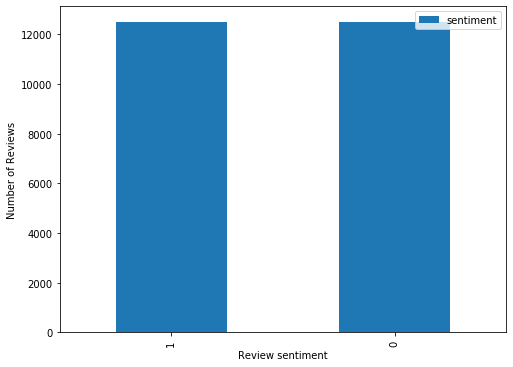

In [55]:
plt.figure(figsize=(8,6))
df_train['sentiment'].value_counts().plot(kind='bar')
plt.xlabel('Review sentiment')
plt.ylabel('Number of Reviews')
plt.legend(loc='upper right')
plt.show();

### Having equal distribution is critical for modelling

In [8]:
#Clean the train review data
df_train['cleaned_review'] = df_train['review'].apply(lambda x: clean_text(x))
df_train['cleaned_review'].head(3)

0    stuff going moment mj started listening music ...
1    classic war world timothy hines entertaining f...
2    film start manager nicholas bell giving welcom...
Name: cleaned_review, dtype: object

### Finding distribution

In [61]:
df_train['review_length'] = df_train['cleaned_review'].apply(lambda x: len(x.split(' ')))
df_train.head()

,id,sentiment,review,cleaned_review,review_length
0,5814_8,1,With all this stuff going down at the moment w...,stuff going moment mj started listening music ...,227
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi...",classic war world timothy hines entertaining f...,81
2,7759_3,0,The film starts with a manager (Nicholas Bell)...,film start manager nicholas bell giving welcom...,241
3,3630_4,0,It must be assumed that those who praised this...,must assumed praised film greatest filmed oper...,193
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...,superbly trashy wondrously unpretentious explo...,210


In [66]:
mean = df_train['review_length'].mean()
median = df_train['review_length'].median()
mode = df_train['review_length'].mode()[0]

mean, median, mode

(123.35284, 91.0, 63)

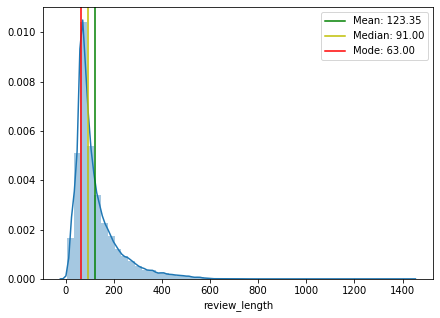

In [91]:
plt.figure(figsize=(7,5))
sb.distplot(df_train['review_length'], norm_hist=True)
plt.axvline(label=f'Mean: {mean:.2f}'.format(mean), x=123, ymin=0, ymax=1, c='g')
plt.axvline(label=f'Median: {median:.2f}', x=91, ymin=0, ymax=1, c='y')
plt.axvline(label=f'Mode: {mode:.2f}', x=63, ymin=0, ymax=1, c='r')
plt.legend(loc='best')
plt.show();

---

## Word2Vec

In [94]:
import gensim
from gensim.models import Word2Vec, Phrases

In [95]:
bigrams = Phrases(df_train['cleaned_review'])

In [103]:
bigrams['space station near the solar system'.split()]

['space', 'station', 'near', 'the', 'solar', 'system']

In [104]:
trigrams = Phrases(bigrams[df_train['cleaned_review']])

In [107]:
trigrams.corpus_word_count

20558766

In [108]:
trigrams.max_vocab_size

40000000

In [109]:
trigrams_model = Word2Vec(sentences=trigrams[bigrams[df_train['cleaned_review']]], size=256, min_count=3, workers=4)

In [110]:
trigrams_model.corpus_count

25000

In [117]:
df_train.loc[0,'cleaned_review']

'stuff going moment mj started listening music watching odd documentary watched wiz watched moonwalker maybe want get certain insight guy thought really cool eighty maybe make mind whether guilty innocent moonwalker part biography part feature film remember going see cinema originally released subtle message mj feeling towards press also obvious message drug bad kay br br visually impressive course michael jackson unless remotely like mj anyway going hate find boring may call mj egotist consenting making movie mj fan would say made fan true really nice br br actual feature film bit finally start minute excluding smooth criminal sequence joe pesci convincing psychopathic powerful drug lord want mj dead bad beyond mj overheard plan nah joe pesci character ranted wanted people know supplying drug etc dunno maybe hate mj music br br lot cool thing like mj turning car robot whole speed demon sequence also director must patience saint came filming kiddy bad sequence usually director hate wor

### Implemention #2

In [192]:
#Sentences = list of list of corpus
corpus=[eachrev.split(' ') for eachrev in df_train['cleaned_review']]

In [195]:
w2v = Word2Vec(sentences=corpus, size=256)

In [203]:
vocab = [w2v.wv.vocab]
vocab[:2]

[{'stuff': <gensim.models.keyedvectors.Vocab at 0x253fe19bc50>,
  'going': <gensim.models.keyedvectors.Vocab at 0x253fe19be10>,
  'moment': <gensim.models.keyedvectors.Vocab at 0x253fe19bcc0>,
  'mj': <gensim.models.keyedvectors.Vocab at 0x253fe19be80>,
  'started': <gensim.models.keyedvectors.Vocab at 0x253fe19b160>,
  'listening': <gensim.models.keyedvectors.Vocab at 0x253fe19bf60>,
  'music': <gensim.models.keyedvectors.Vocab at 0x253fe19bfd0>,
  'watching': <gensim.models.keyedvectors.Vocab at 0x253fb0206d8>,
  'odd': <gensim.models.keyedvectors.Vocab at 0x253fb020438>,
  'documentary': <gensim.models.keyedvectors.Vocab at 0x253fb020978>,
  'watched': <gensim.models.keyedvectors.Vocab at 0x253fb0209e8>,
  'wiz': <gensim.models.keyedvectors.Vocab at 0x253fb0202e8>,
  'moonwalker': <gensim.models.keyedvectors.Vocab at 0x253fb020908>,
  'maybe': <gensim.models.keyedvectors.Vocab at 0x253fb020208>,
  'want': <gensim.models.keyedvectors.Vocab at 0x253fb020358>,
  'get': <gensim.models.k

In [199]:
w2v.wv.most_similar('music')

[('soundtrack', 0.8326591849327087),
 ('song', 0.8015882968902588),
 ('lyric', 0.7475755214691162),
 ('tune', 0.7139605283737183),
 ('score', 0.7014411687850952),
 ('catchy', 0.6980379819869995),
 ('singing', 0.6906015872955322),
 ('dancing', 0.6647820472717285),
 ('scenery', 0.6613697409629822),
 ('dance', 0.6560667157173157)]

In [205]:
w2v.wv.most_similar('actor')

[('actress', 0.7588638067245483),
 ('performer', 0.7114489078521729),
 ('casting', 0.6735978126525879),
 ('talent', 0.6031596660614014),
 ('professional', 0.5955723524093628),
 ('comedian', 0.5948448181152344),
 ('talented', 0.5722163319587708),
 ('acting', 0.565491795539856),
 ('role', 0.565075695514679),
 ('cast', 0.5590618252754211)]

---

### Working with Test Data

In [10]:
#Clearn test review data
df_test['cleaned_review'] = df_test['review'].apply(lambda x: clean_text(x))
df_test['cleaned_review'].head(3)

0    naturally film main theme mortality nostalgia ...
1    movie disaster within disaster film full great...
2    movie kid saw tonight child loved one point ki...
Name: cleaned_review, dtype: object

In [14]:
#Average length of review
AvgLength  = df_train['cleaned_review'].apply(lambda x: len(x.split(' '))).mean()
print('Average length of Review: ', AvgLength)

Average length of Review:  123.35284


In [12]:
#Preprocess cleaned review for modelling
tokenizer = Tokenizer(num_words = 6000)
tokenizer.fit_on_texts(df_train['cleaned_review'])

In [15]:
#Sequence Train and Test review
train_sequence = tokenizer.texts_to_sequences(df_train['cleaned_review'])
test_sequence = tokenizer.texts_to_sequences(df_test['cleaned_review'])

In [16]:
#Pad Sequence for equal length of review
X_train = pad_sequences(train_sequence, maxlen=130)
X_test = pad_sequences(test_sequence, maxlen=130)

In [17]:
#Set up target value
y_train = df_train['sentiment']

In [18]:
#Review shape of training set
X_train.shape, y_train.shape

((25000, 130), (25000,))

In [19]:
#Review test set
X_test.shape

(25000, 130)

## Building the NN Model

In [22]:
model = Sequential()

#Add embedding layer
model.add(Embedding(6000, 128))

#Add Bidrectional RNN Layer
model.add(Bidirectional(LSTM(64, return_sequences=True)))

#Add Dense Layer
model.add(Dense(128, activation='relu'))

#Add MaxPooling Layer
model.add(GlobalMaxPool1D())

#Add Output Layer
model.add(Dense(1, activation='sigmoid'))

#Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 128)         768000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 128)         98816     
_________________________________________________________________
dense_3 (Dense)              (None, None, 128)         16512     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 883,457
Trainable params: 883,457
Non-trainable params: 0
_________________________________________________________________


In [23]:
#Fit the model
model.fit(X_train, y_train, batch_size=100, epochs=3, validation_split=0.2)

C:\Users\rajas\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20000 samples, validate on 5000 samples
Epoch 1/3
20000/20000 [==============================] - 212s 11ms/step - loss: 0.4032 - accuracy: 0.8098 - val_loss: 0.2997 - val_accuracy: 0.8702
Epoch 2/3
20000/20000 [==============================] - 197s 10ms/step - loss: 0.2276 - accuracy: 0.9115 - val_loss: 0.3107 - val_accuracy: 0.8708
Epoch 3/3
20000/20000 [==============================] - 197s 10ms/step - loss: 0.1811 - accuracy: 0.9317 - val_loss: 0.3598 - val_accuracy: 0.8620


In [26]:
sentiment_prediction = model.predict(X_train)

In [32]:
#Evaluating model prediction
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, roc_auc_score, roc_curve

In [28]:
prediction = (sentiment_prediction)>0.5
prediction[:5]

array([[False],
       [ True],
       [False],
       [False],
       [ True]])

In [29]:
#F1 Score
f1_score(y_train, prediction)

0.9429608186896075

In [30]:
#Model Accuracy
accuracy_score(y_train, prediction)

0.94404

In [31]:
#Plotting Confusion Matrix
confusion_matrix(y_train, prediction)

array([[12037,   463],
       [  936, 11564]], dtype=int64)

In [33]:
#Plot roc curve
roc_auc_score(y_train, prediction)

0.9440400000000001

In [34]:
roc_curve(y_train, prediction)

(array([0.     , 0.03704, 1.     ]),
 array([0.     , 0.92512, 1.     ]),
 array([2, 1, 0]))

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline

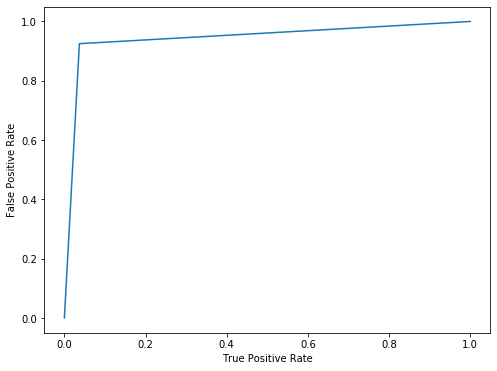

In [48]:
plt.figure(figsize=(8,6))
fpr, tpr, _ = roc_curve(y_train, prediction)
plt.plot(fpr, tpr)
plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')
plt.show();

### Word Embedding

In [143]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vectorizer = TfidfVectorizer()
data = ['This is a sample text']
word_embed = vectorizer.fit_transform(data)

In [144]:
print(word_embed.toarray())

[[0.5 0.5 0.5 0.5]]


In [145]:
vocab = vectorizer.fit(data)
print(vocab.get_feature_names())

['is', 'sample', 'text', 'this']


In [174]:
data = 'This is a sample text'

In [172]:
import nltk
import gensim
from gensim.models.word2vec import LineSentence

In [180]:
data = 'This is a sample text'
data=data.split(' ')
data = [data, data]
data

[['This', 'is', 'a', 'sample', 'text'], ['This', 'is', 'a', 'sample', 'text']]

In [181]:
model= gensim.models.Word2Vec(sentences=data, min_count=1)

In [182]:
model.wv.vocab

{'This': <gensim.models.keyedvectors.Vocab at 0x253fb022358>,
 'is': <gensim.models.keyedvectors.Vocab at 0x253fb022d68>,
 'a': <gensim.models.keyedvectors.Vocab at 0x253fb022e48>,
 'sample': <gensim.models.keyedvectors.Vocab at 0x253fb022588>,
 'text': <gensim.models.keyedvectors.Vocab at 0x253fb022ac8>}

In [183]:
model.wv.most_similar('is')

[('sample', 0.02002655155956745),
 ('a', -0.06037051975727081),
 ('This', -0.0755176693201065),
 ('text', -0.21062900125980377)]

In [155]:
data=model.most_similar('g')
print(data)

[('w', 0.36052533984184265), ('t', 0.31728971004486084), ('ù', 0.28967294096946716), ('s', 0.2755500078201294), ('ï', 0.27182328701019287), ('½', 0.23744148015975952), ('ä', 0.21943676471710205), ('c', 0.1989104449748993), ('å', 0.17435164749622345), ('ø', 0.17289087176322937)]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


In [206]:
model = Sequential()

#Add embedding layer
# model.add(Embedding(6000, 128))

model.add(Embedding( 
        input_dim = w2v.wv.vectors.shape[0], 
        output_dim = w2v.wv.vectors.shape[1],  
        weights = [w2v.wv.vectors], 
        trainable=False)) 

#Add Bidrectional RNN Layer
model.add(Bidirectional(LSTM(64, return_sequences=True)))

#Add Dense Layer
model.add(Dense(128, activation='relu'))

#Add MaxPooling Layer
model.add(GlobalMaxPool1D())

#Add Output Layer
model.add(Dense(1, activation='sigmoid'))

#Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 256)         6540800   
_________________________________________________________________
bidirectional_3 (Bidirection (None, None, 128)         164352    
_________________________________________________________________
dense_5 (Dense)              (None, None, 128)         16512     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 6,721,793
Trainable params: 180,993
Non-trainable params: 6,540,800
_________________________________________________________________


In [207]:
model.fit(X_train, y_train, batch_size=200, epochs=4, validation_split=0.25)

Train on 18750 samples, validate on 6250 samples
Epoch 1/4
18750/18750 [==============================] - 231s 12ms/step - loss: 0.5787 - accuracy: 0.6855 - val_loss: 0.5023 - val_accuracy: 0.7531
Epoch 2/4
18750/18750 [==============================] - 239s 13ms/step - loss: 0.4538 - accuracy: 0.7856 - val_loss: 0.4796 - val_accuracy: 0.7666
Epoch 3/4
18750/18750 [==============================] - 251s 13ms/step - loss: 0.4084 - accuracy: 0.8127 - val_loss: 0.4367 - val_accuracy: 0.7954
Epoch 4/4
18750/18750 [==============================] - 289s 15ms/step - loss: 0.3669 - accuracy: 0.8363 - val_loss: 0.4013 - val_accuracy: 0.8147


In [208]:
pred_test = model.predict(X_test)

In [209]:
pred_train = model.predict(X_train)

In [210]:
pred = pred_train>0.5

In [211]:
pred[:5]

array([[False],
       [ True],
       [False],
       [False],
       [False]])

In [212]:
#Plot roc curve
roc_auc_score(y_train, pred)

0.85248

In [215]:
model.get_config()

{'name': 'sequential_3',
 'layers': [{'class_name': 'Embedding',
   'config': {'name': 'embedding_3',
    'trainable': False,
    'batch_input_shape': (None, None),
    'dtype': 'float32',
    'input_dim': 25550,
    'output_dim': 256,
    'embeddings_initializer': {'class_name': 'RandomUniform',
     'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None}},
    'embeddings_regularizer': None,
    'activity_regularizer': None,
    'embeddings_constraint': None,
    'mask_zero': False,
    'input_length': None}},
  {'class_name': 'Bidirectional',
   'config': {'name': 'bidirectional_3',
    'trainable': True,
    'dtype': 'float32',
    'layer': {'class_name': 'LSTM',
     'config': {'name': 'lstm_3',
      'trainable': True,
      'dtype': 'float32',
      'return_sequences': True,
      'return_state': False,
      'go_backwards': False,
      'stateful': False,
      'unroll': False,
      'units': 64,
      'activation': 'tanh',
      'recurrent_activation': 'sigmoid',
      'use_

In [216]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [217]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',  
                                            patience=3,  
                                            verbose=1,  
                                            factor=0.5,  
                                            min_lr=0.00001)

In [221]:
learning_rate_reduction.best

-inf